In [1]:
"""
author: Mihai Suteu
date: 15/05/19
"""

import os
import sys
import h5py
import torch
import shutil
import random
import tarfile
import zipfile
import requests
import numpy as np
import time

from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_url
from torchvision import datasets, models, transforms
from torch import nn
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable

FORCE_CPU = False

if FORCE_CPU:
    device = torch.device("cpu")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NYUv2(Dataset):
    """
    PyTorch wrapper for the NYUv2 dataset focused on multi-task learning.
    Data sources available: RGB, Semantic Segmentation, Surface Normals, Depth Images.
    If no transformation is provided, the image type will not be returned.

    ### Output
    All images are of size: 640 x 480

    1. RGB: 3 channel input image

    2. Semantic Segmentation: 1 channel representing one of the 14 (0 -
    background) classes. Conversion to int will happen automatically if
    transformation ends in a tensor.

    3. Surface Normals: 3 channels, with values in [0, 1].

    4. Depth Images: 1 channel with floats representing the distance in meters.
    Conversion will happen automatically if transformation ends in a tensor.
    """

    def __init__(
        self,
        root: str,
        train: bool = True,
        download: bool = False,
        rgb_transform=None,
        seg_transform=None,
        sn_transform=None,
        depth_transform=None,
    ):
        """
        Will return tuples based on what data source has been enabled (rgb, seg etc).

        :param root: path to root folder (eg /data/NYUv2)
        :param train: whether to load the train or test set
        :param download: whether to download and process data if missing
        :param rgb_transform: the transformation pipeline for rbg images
        :param seg_transform: the transformation pipeline for segmentation images. If
        the transformation ends in a tensor, the result will be automatically
        converted to int in [0, 14)
        :param sn_transform: the transformation pipeline for surface normal images
        :param depth_transform: the transformation pipeline for depth images. If the
        transformation ends in a tensor, the result will be automatically converted
        to meters
        """
        super().__init__()
        self.root = root

        self.rgb_transform = rgb_transform
        self.seg_transform = seg_transform
        self.sn_transform = sn_transform
        self.depth_transform = depth_transform

        self.train = train
        self._split = "train" if train else "test"

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError(
                "Dataset not complete." + " You can use download=True to download it"
            )

        # rgb folder as ground truth
        self._files = sorted(os.listdir(os.path.join(root, f"{self._split}_rgb")))

    def __getitem__(self, index: int):
        folder = lambda name: os.path.join(self.root, f"{self._split}_{name}")
        seed = random.randrange(sys.maxsize)
        imgs = []

        if self.rgb_transform is not None:
            random.seed(seed)
            img = Image.open(os.path.join(folder("rgb"), self._files[index]))
            img = self.rgb_transform(img)
            img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
            imgs.append(img)

        if self.seg_transform is not None:
            random.seed(seed)
            img = Image.open(os.path.join(folder("seg13"), self._files[index]))
            img = self.seg_transform(img)
            # if isinstance(img, torch.Tensor):
            #     # ToTensor scales to [0, 1] by default
            #     img = (img * 255).long()
            img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
            imgs.append(img)

        if self.sn_transform is not None:
            random.seed(seed)
            img = Image.open(os.path.join(folder("sn"), self._files[index]))
            img = self.sn_transform(img)
            img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
            imgs.append(img)

        if self.depth_transform is not None:
            random.seed(seed)
            img = Image.open(os.path.join(folder("depth"), self._files[index]))
            img = self.depth_transform(img)
            if isinstance(img, torch.Tensor):
                # depth png is uint16
                img = img.float() / 1e4
            img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
            imgs.append(img)

        resize = transforms.Resize(512)
        transform = transforms.Compose([resize])
        for i, img in enumerate(imgs):
            imgs[i] = transform(imgs[i])
            
        
        return imgs

    def __len__(self):
        return len(self._files)

    def __repr__(self):
        fmt_str = f"Dataset {self.__class__.__name__}\n"
        fmt_str += f"    Number of data points: {self.__len__()}\n"
        fmt_str += f"    Split: {self._split}\n"
        fmt_str += f"    Root Location: {self.root}\n"
        tmp = "    RGB Transforms: "
        fmt_str += "{0}{1}\n".format(
            tmp, self.rgb_transform.__repr__().replace("\n", "\n" + " " * len(tmp))
        )
        tmp = "    Seg Transforms: "
        fmt_str += "{0}{1}\n".format(
            tmp, self.seg_transform.__repr__().replace("\n", "\n" + " " * len(tmp))
        )
        tmp = "    SN Transforms: "
        fmt_str += "{0}{1}\n".format(
            tmp, self.sn_transform.__repr__().replace("\n", "\n" + " " * len(tmp))
        )
        tmp = "    Depth Transforms: "
        fmt_str += "{0}{1}\n".format(
            tmp, self.depth_transform.__repr__().replace("\n", "\n" + " " * len(tmp))
        )
        return fmt_str

    def _check_exists(self) -> bool:
        """
        Only checking for folder existence
        """
        try:
            for split in ["train", "test"]:
                for part, transform in zip(
                    ["rgb", "seg13", "sn", "depth"],
                    [
                        self.rgb_transform,
                        self.seg_transform,
                        self.sn_transform,
                        self.depth_transform,
                    ],
                ):
                    if transform is None:
                        continue
                    path = os.path.join(self.root, f"{split}_{part}")
                    if not os.path.exists(path):
                        raise FileNotFoundError("Missing Folder")
        except FileNotFoundError as e:
            return False
        return True

    def download(self):
        if self._check_exists():
            return
        if self.rgb_transform is not None:
            download_rgb(self.root)
        if self.seg_transform is not None:
            download_seg(self.root)
        if self.sn_transform is not None:
            download_sn(self.root)
        if self.depth_transform is not None:
            download_depth(self.root)
        print("Done!")


def download_rgb(root: str):
    train_url = "http://www.doc.ic.ac.uk/~ahanda/nyu_train_rgb.tgz"
    test_url = "http://www.doc.ic.ac.uk/~ahanda/nyu_test_rgb.tgz"

    def _proc(url: str, dst: str):
        if not os.path.exists(dst):
            tar = os.path.join(root, url.split("/")[-1])
            if not os.path.exists(tar):
                download_url(url, root)
            if os.path.exists(tar):
                _unpack(tar)
                _replace_folder(tar.rstrip(".tgz"), dst)
                _rename_files(dst, lambda x: x.split("_")[2])

    _proc(train_url, os.path.join(root, "train_rgb"))
    _proc(test_url, os.path.join(root, "test_rgb"))


def download_seg(root: str):
    train_url = "https://github.com/ankurhanda/nyuv2-meta-data/raw/master/train_labels_13/nyuv2_train_class13.tgz"
    test_url = "https://github.com/ankurhanda/nyuv2-meta-data/raw/master/test_labels_13/nyuv2_test_class13.tgz"

    def _proc(url: str, dst: str):
        if not os.path.exists(dst):
            tar = os.path.join(root, url.split("/")[-1])
            if not os.path.exists(tar):
                download_url(url, root)
            if os.path.exists(tar):
                _unpack(tar)
                _replace_folder(tar.rstrip(".tgz"), dst)
                _rename_files(dst, lambda x: x.split("_")[3])

    _proc(train_url, os.path.join(root, "train_seg13"))
    _proc(test_url, os.path.join(root, "test_seg13"))


def download_sn(root: str):
    url = "https://www.dropbox.com/s/dn5sxhlgml78l03/nyu_normals_gt.zip"
    train_dst = os.path.join(root, "train_sn")
    test_dst = os.path.join(root, "test_sn")

    if not os.path.exists(train_dst) or not os.path.exists(test_dst):
        tar = os.path.join(root, url.split("/")[-1])
        if not os.path.exists(tar):
            req = requests.get(url + "?dl=1") # dropbox
            with open(tar, 'wb') as f:
                f.write(req.content)
        if os.path.exists(tar):
            _unpack(tar)
            if not os.path.exists(train_dst):
                _replace_folder(
                    os.path.join(root, "nyu_normals_gt", "train"), train_dst
                )
                _rename_files(train_dst, lambda x: x[1:])
            if not os.path.exists(test_dst):
                _replace_folder(os.path.join(root, "nyu_normals_gt", "test"), test_dst)
                _rename_files(test_dst, lambda x: x[1:])
            shutil.rmtree(os.path.join(root, "nyu_normals_gt"))


def download_depth(root: str):
    url = (
        "http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat"
    )
    train_dst = os.path.join(root, "train_depth")
    test_dst = os.path.join(root, "test_depth")

    if not os.path.exists(train_dst) or not os.path.exists(test_dst):
        tar = os.path.join(root, url.split("/")[-1])
        if not os.path.exists(tar):
            download_url(url, root)
        if os.path.exists(tar):
            train_ids = [
                f.split(".")[0] for f in os.listdir(os.path.join(root, "train_rgb"))
            ]
            _create_depth_files(tar, root, train_ids)


def _unpack(file: str):
    """
    Unpacks tar and zip, does nothing for any other type
    :param file: path of file
    """
    path = file.rsplit(".", 1)[0]

    if file.endswith(".tgz"):
        tar = tarfile.open(file, "r:gz")
        tar.extractall(path)
        tar.close()
    elif file.endswith(".zip"):
        zip = zipfile.ZipFile(file, "r")
        zip.extractall(path)
        zip.close()


def _rename_files(folder: str, rename_func: callable):
    """
    Renames all files inside a folder based on the passed rename function
    :param folder: path to folder that contains files
    :param rename_func: function renaming filename (not including path) str -> str
    """
    imgs_old = os.listdir(folder)
    imgs_new = [rename_func(file) for file in imgs_old]
    for img_old, img_new in zip(imgs_old, imgs_new):
        shutil.move(os.path.join(folder, img_old), os.path.join(folder, img_new))


def _replace_folder(src: str, dst: str):
    """
    Rename src into dst, replacing/overwriting dst if it exists.
    """
    if os.path.exists(dst):
        shutil.rmtree(dst)
    shutil.move(src, dst)


def _create_depth_files(mat_file: str, root: str, train_ids: list):
    """
    Extract the depth arrays from the mat file into images
    :param mat_file: path to the official labelled dataset .mat file
    :param root: The root directory of the dataset
    :param train_ids: the IDs of the training images as string (for splitting)
    """
    os.mkdir(os.path.join(root, "train_depth"))
    os.mkdir(os.path.join(root, "test_depth"))
    train_ids = set(train_ids)

    depths = h5py.File(mat_file, "r")["depths"]
    for i in range(len(depths)):
        img = (depths[i] * 1e4).astype(np.uint16).T
        id_ = str(i + 1).zfill(4)
        folder = "train" if id_ in train_ids else "test"
        save_path = os.path.join(root, f"{folder}_depth", id_ + ".png")
        Image.fromarray(img).save(save_path)


In [2]:
from torchvision import transforms

t = transforms.Compose([transforms.CenterCrop(400), transforms.ToTensor()])
train = NYUv2(root="content/NYUv2", train=True, download=True, rgb_transform=t, seg_transform=t, sn_transform=None, depth_transform=None)
test = NYUv2(root="content/NYUv2", train=False, download=True, rgb_transform=t, seg_transform=t, sn_transform=None, depth_transform=None)

  0%|          | 0/288387182 [00:00<?, ?it/s]

  0%|          | 0/237917075 [00:00<?, ?it/s]

  0%|          | 0/4841620 [00:00<?, ?it/s]

  0%|          | 0/3955310 [00:00<?, ?it/s]

Done!


In [3]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train, batch_size=16)
test_dl = DataLoader(test, batch_size=16)

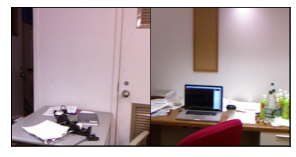

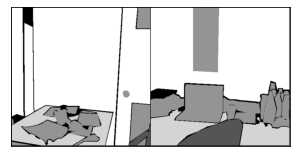

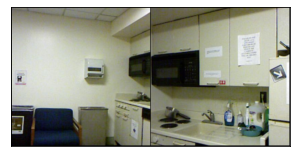

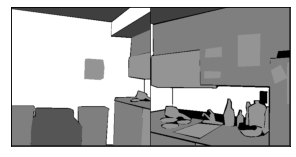

In [4]:
import torchvision
import matplotlib as mpl
import matplotlib.pyplot as plt

def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.cpu().numpy().transpose((1, 2, 0))
  inp = (inp - np.min(inp)) / (np.max(inp) - np.min(inp))
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  
  if len(inp.shape) == 3 and inp.shape[-1] == 1:
    inp = np.reshape(inp, (inp.shape[0], inp.shape[1]))

  ax.imshow(inp, cmap="hsv")
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
train_in, test_in = next(iter(train_dl)), next(iter(test_dl))

fixed_x = test_in[0].to(device=device)
fixed_y = test_in[1].to(device=device)

# Make a grid from batch
for i in [0, 1]:
  out = torchvision.utils.make_grid(train_in[i][:2], nrow=4)
  fig, ax = plt.subplots(1, figsize=(5, 5))
  imshow(out, ax=ax)

for d in [fixed_x, fixed_y]:
   out = torchvision.utils.make_grid(d[:2], nrow=4)
   fig, ax = plt.subplots(1, figsize=(5, 5))
   imshow(out, ax=ax)


# Now we need to train a network for semantic segmentation

In [5]:
def normal_init(m, mean, std):
  """
  Helper function. Initialize model parameter with given mean and std.
  """
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    # delete start
    m.weight.data.normal_(mean, std).to(device=device) 
    m.bias.data.zero_().to(device=device)
    # delete end

In [6]:
class generator(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()
    ###########################################################################
    # TODO: Build your Unet generator encoder with the layer sizes            #
    # You can also check the size with the model summary below                #
    ###########################################################################

    
    # layer 1 - C64
    self.encConv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(4, 4), stride=2, padding=1)
    # torch.nn.functional.leaky_relu(0.2), 

    # layer 2 - C128
    self.encConv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm2 = nn.BatchNorm2d(128)
    #torch.nn.functional.leaky_relu(0.2) ,

    # layer 3 - C256
    self.encConv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm3 = nn.BatchNorm2d(256)
    #torch.nn.functional.leaky_relu(0.2),

    # layer 4 - C512
    self.encConv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm4 = nn.BatchNorm2d(512)
    #torch.nn.functional.leaky_relu(0.2),

    # layer 5 - C512
    self.encConv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm5 = nn.BatchNorm2d(512)
    #torch.nn.functional.leaky_relu(0.2),

    # layer 6 - C512
    self.encConv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm6 = nn.BatchNorm2d(512)
    #torch.nn.functional.leaky_relu(0.2),

    # layer 7 - C512
    self.encConv7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm7 = nn.BatchNorm2d(512)
    #torch.nn.functional.leaky_relu(0.2),

    # layer 8 - C512
    self.encConv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=2, padding=1)
    #torch.nn.functional.leaky_relu(0.2)

      
    

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    ###########################################################################
    # TODO: Build your Unet generator decoder with the layer sizes            #
    ###########################################################################
   
    # Layer 1 - C512
    self.decConv1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm1 = nn.BatchNorm2d(512)
    #torch.nn.ReLU(),

    # Layer 2 - C512
    self.decConv2 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm2 = nn.BatchNorm2d(512)
    #torch.nn.ReLU(),

    # Layer 3 - C512
    self.decConv3 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm3 = nn.BatchNorm2d(512)
    #torch.nn.ReLU(),

    # Layer 4 - C512
    self.decConv4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm4 = nn.BatchNorm2d(512)
    #torch.nn.ReLU(),

    # Layer 5 - C256
    self.decConv5 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm5 = nn.BatchNorm2d(256)
    #torch.nn.ReLU(),

    # Layer 6 - C128
    self.decConv6 = nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm6 = nn.BatchNorm2d(128)
    #torch.nn.ReLU(),

    # Layer 7 - C64
    self.decConv7 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm7 = nn.BatchNorm2d(64)
    #torch.nn.ReLU(),

    # Layer 8 - C3
    self.decConv8 = nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm8 = nn.BatchNorm2d(3)
    #torch.nn.ReLU(),


    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    ###########################################################################
    # TODO: Implement the forward pass of generator                           #
    ###########################################################################
    # encoding

    e1_c = self.encConv1(input)
    
    e2_c = self.encConv2(nn.functional.leaky_relu(e1_c, 0.2))
    e2_bn = self.encBatchNorm2(e2_c)

    e3_c = self.encConv3(nn.functional.leaky_relu(e2_bn, 0.2))
    e3_bn = self.encBatchNorm3(e3_c)
    
    e4_c = self.encConv4(nn.functional.leaky_relu(e3_bn, 0.2))
    e4_bn = self.encBatchNorm4(e4_c)

    e5_c = self.encConv5(nn.functional.leaky_relu(e4_bn, 0.2))
    e5_bn = self.encBatchNorm5(e5_c)

    e6_c = self.encConv6(nn.functional.leaky_relu(e5_bn, 0.2))
    e6_bn = self.encBatchNorm6(e6_c)

    e7_c = self.encConv7(nn.functional.leaky_relu(e6_bn, 0.2))
    e7_bn = self.encBatchNorm7(e7_c)

    e8_c = self.encConv8(nn.functional.leaky_relu(e7_bn, 0.2))

    enc_output = nn.functional.leaky_relu(e8_c, 0.2)

    # decoding
    # Hint: you can use torch.cat to concatenate the decoder and the encoder inputs

    d1_c = self.decConv1(enc_output)
    d1_bn = self.decBatchNorm1(d1_c)

    d2_in = torch.cat([e7_bn, d1_bn], 1)
  
    d2_c = self.decConv2(nn.functional.relu(d2_in))
    d2_bn = self.decBatchNorm2(d2_c) 

    d3_in = torch.cat([e6_bn, d2_bn], 1)

    d3_c = self.decConv3(nn.functional.relu(d3_in))
    d3_bn = self.decBatchNorm3(d3_c) 

    d4_in = torch.cat([e5_bn, d3_bn], 1)

    d4_c = self.decConv4(nn.functional.relu(d4_in))
    d4_bn = self.decBatchNorm4(d4_c) 

    d5_in = torch.cat([e4_bn, d4_bn], 1)

    d5_c = self.decConv5(nn.functional.relu(d5_in))
    d5_bn = self.decBatchNorm5(d5_c) 

    d6_in = torch.cat([e3_bn, d5_bn], 1)

    d6_c = self.decConv6(nn.functional.relu(d6_in))
    d6_bn = self.decBatchNorm6(d6_c) 

    d7_in = torch.cat([e2_bn, d6_bn], 1)

    d7_c = self.decConv7(nn.functional.relu(d7_in))
    d7_bn = self.decBatchNorm7(d7_c) 

    d8_in = torch.cat([e1_c, d7_bn], 1)

    d8_c = self.decConv8(nn.functional.relu(d8_in)) 

    output = nn.functional.sigmoid(d8_c)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return output


In [8]:
def process_image(img):
  tmp = img.cpu().data.numpy().transpose(1, 2, 0)
  if len(tmp.shape) == 3 and tmp.shape[-1] == 1:
    tmp = np.reshape(tmp, (tmp.shape[0], tmp.shape[1]))
  return (tmp - np.min(tmp)) / (np.max(tmp) - np.min(tmp))
  
def show_result(G, x_, y_, num_epoch):
  predict_images = G(x_)

  # compute average x and y value. see what they are
  x_mean = torch.mean(predict_images)
  y_mean = torch.mean(y_)

  print('predict_images mean: ', x_mean)
  print('y_ mean: ', y_mean)
  
  fig, ax = plt.subplots(x_.size()[0], 3, figsize=(6,10))

  for i in range(x_.size()[0]):
    ax[i, 0].get_xaxis().set_visible(False)
    ax[i, 0].get_yaxis().set_visible(False)
    ax[i, 1].get_xaxis().set_visible(False)
    ax[i, 1].get_yaxis().set_visible(False)
    ax[i, 2].get_xaxis().set_visible(False)
    ax[i, 2].get_yaxis().set_visible(False)
    ax[i, 0].cla()
    ax[i, 0].imshow(process_image(x_[i]))
    ax[i, 1].cla()
    ax[i, 1].imshow(process_image(predict_images[i]))
    ax[i, 2].cla()
    ax[i, 2].imshow(process_image(y_[i]))
  
  plt.tight_layout()
  label_epoch = 'Epoch {0}'.format(num_epoch)
  fig.text(0.5, 0, label_epoch, ha='center')
  label_input = 'Input'
  fig.text(0.18, 1, label_input, ha='center')
  label_output = 'Output'
  fig.text(0.5, 1, label_output, ha='center')
  label_truth = 'Ground truth'
  fig.text(0.81, 1, label_truth, ha='center')

  plt.show()

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.nn.functional.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [10]:
# module that computes CE loss and Dice loss of sofrmax with one_hot 

CELoss = nn.CrossEntropyLoss()
diceLoss = DiceLoss()
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
    
    def forward(self, inputs, targets):
        loss = CELoss(inputs, targets)
        loss += diceLoss(
            torch.nn.functional.softmax(inputs, dim=1).float(), 
           targets.float())
        return loss

In [40]:

#loss_func = nn.BCELoss().to(device=device)
#loss_func = DiceLoss().to(device=device) 
#loss_func = nn.L1Loss().to(device=device)
#loss_func = Loss().to(device=device)
#loss_func = nn.CrossEntropyLoss().to(device=device)
def train_Unet(G, dataloader, num_epochs=20):
    #G_optimizer = optim.Adam(G.parameters(), lr=0.01, betas=[0.5, 0.999])
    
    # use SGD with momentum

    total_losses = []
    
    G_optimizer = optim.SGD(G.parameters(), lr=0.02, momentum=0.8)
    loss_func = nn.MSELoss().to(device=device)
    # lr_reducer = optim.lr_scheduler.ReduceLROnPlateau(
    #     G_optimizer, 
    #     mode='min', 
    #     factor=0.5, 
    #     patience=2, 
    #     threshold=0.01,
    #     verbose=True)

    for epoch in range(num_epochs):

        # have the learning rate decay
        base_lr = 0.005
        lr = base_lr * 0.8
        G_optimizer

        G_losses = []
        epoch_start_time = time.time()
        
        for data in dataloader:
            x = data[0].to(device=device) # images
            y = data[1].to(device=device) # sementic segmentations

            # assert all elements of 0 < y < 1

            G.zero_grad() 
            model_ouput = G(x)
            assert torch.all(y >= 0) and torch.all(y <= 1)
            assert torch.all(x >= 0) and torch.all(x <= 1)
            
            loss = loss_func(model_ouput.float(), y.float())
            loss.backward()
            G_optimizer.step()

            loss_G = loss.detach().item()
            G_losses.append(loss_G)
            #print(loss_G) 
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
        print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
        print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
        #lr_reducer.step(torch.mean(torch.FloatTensor(G_losses)))
        total_losses.append(G_losses)
        
        with torch.no_grad():
            assert torch.all(fixed_x >= 0) and torch.all(fixed_x <= 1)
            assert torch.all(fixed_y >= 0) and torch.all(fixed_y <= 1)
            
            if epoch % 1 == 0:
                show_result(G, fixed_x, fixed_y, (epoch+1))
        
        # append G_losses to total_losses
    
    return total_losses

[1/10] - using time: 5.59 seconds
loss of generator G: 0.110
predict_images mean:  tensor(0.6310, device='cuda:0')
y_ mean:  tensor(0.6198, device='cuda:0')


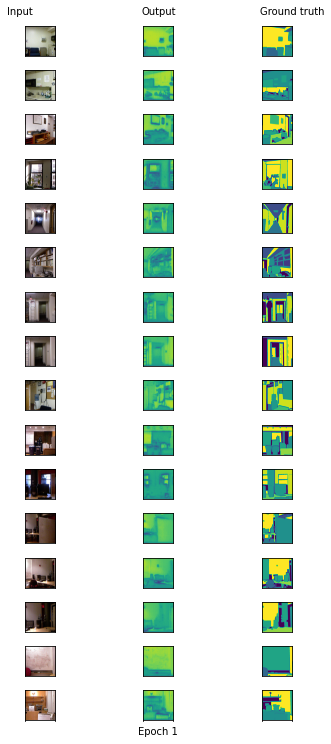

[2/10] - using time: 5.46 seconds
loss of generator G: 0.095
predict_images mean:  tensor(0.5624, device='cuda:0')
y_ mean:  tensor(0.6198, device='cuda:0')


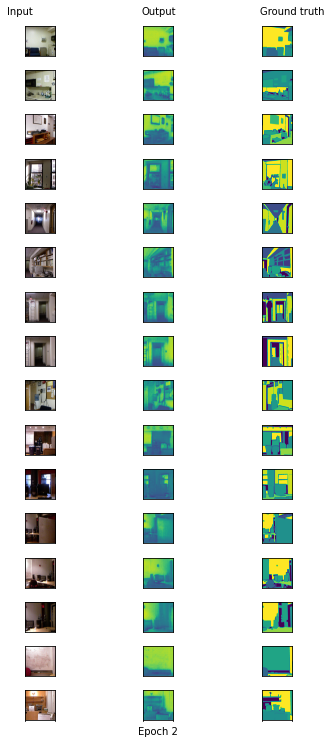

[3/10] - using time: 5.50 seconds
loss of generator G: 0.090
predict_images mean:  tensor(0.5802, device='cuda:0')
y_ mean:  tensor(0.6198, device='cuda:0')


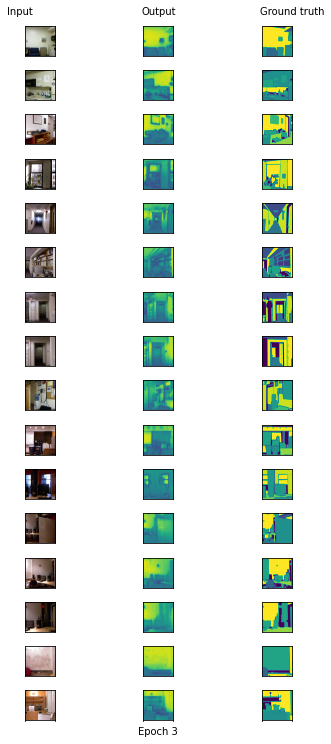

[4/10] - using time: 5.45 seconds
loss of generator G: 0.087
predict_images mean:  tensor(0.5796, device='cuda:0')
y_ mean:  tensor(0.6198, device='cuda:0')


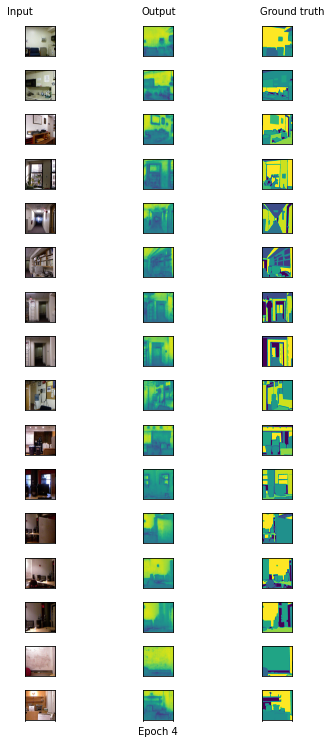

[5/10] - using time: 5.47 seconds
loss of generator G: 0.084
predict_images mean:  tensor(0.5801, device='cuda:0')
y_ mean:  tensor(0.6198, device='cuda:0')


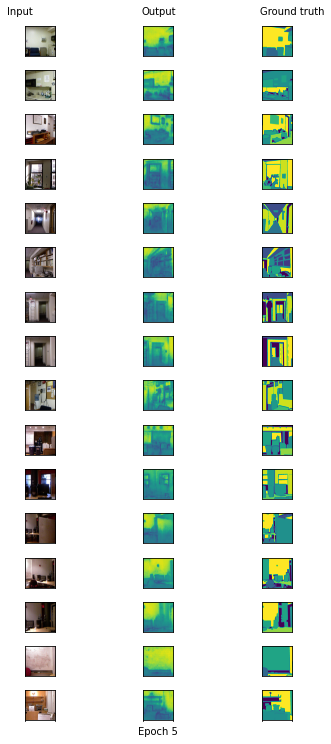

[6/10] - using time: 5.51 seconds
loss of generator G: 0.081
predict_images mean:  tensor(0.5648, device='cuda:0')
y_ mean:  tensor(0.6198, device='cuda:0')


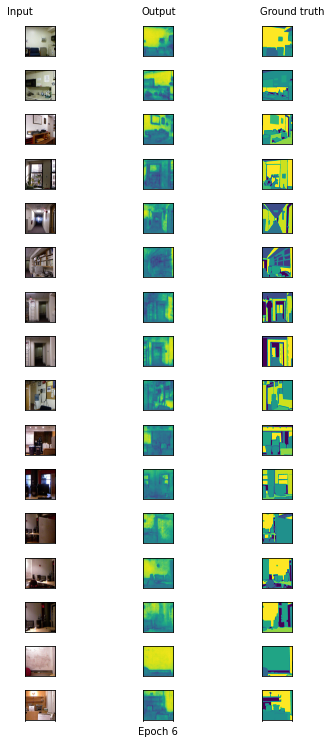

[7/10] - using time: 5.54 seconds
loss of generator G: 0.076
predict_images mean:  tensor(0.5778, device='cuda:0')
y_ mean:  tensor(0.6198, device='cuda:0')


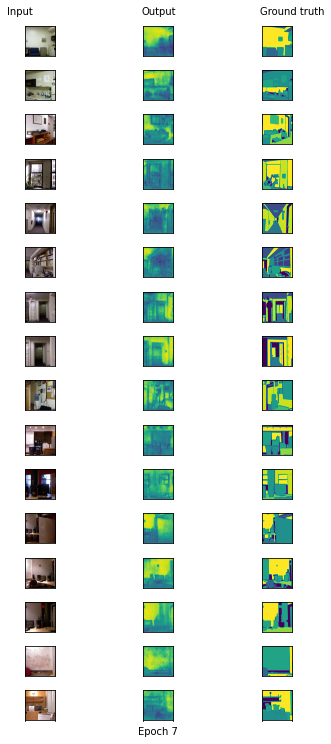

[8/10] - using time: 5.47 seconds
loss of generator G: 0.070
predict_images mean:  tensor(0.5602, device='cuda:0')
y_ mean:  tensor(0.6198, device='cuda:0')


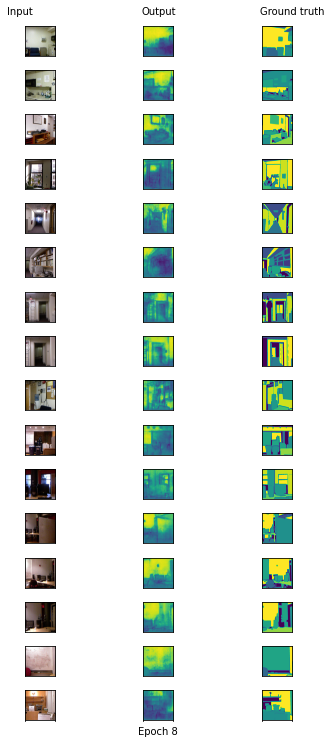

[9/10] - using time: 5.54 seconds
loss of generator G: 0.065
predict_images mean:  tensor(0.5460, device='cuda:0')
y_ mean:  tensor(0.6198, device='cuda:0')


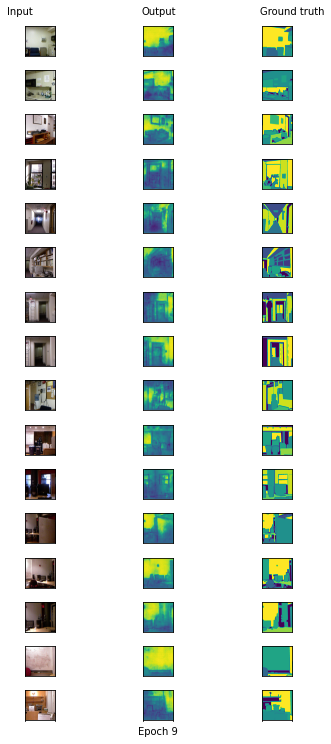

[10/10] - using time: 5.54 seconds
loss of generator G: 0.059
predict_images mean:  tensor(0.5761, device='cuda:0')
y_ mean:  tensor(0.6198, device='cuda:0')


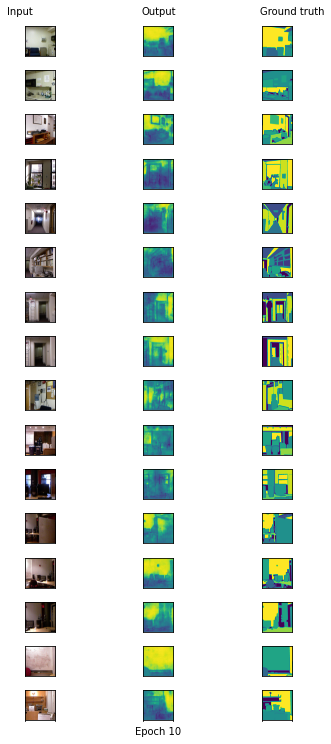

In [41]:
G = generator()
G.to(device=device)  
train_dl = DataLoader(train, batch_size=4, shuffle=True, num_workers=4)
loss = train_Unet(G, train_dl, num_epochs=10)

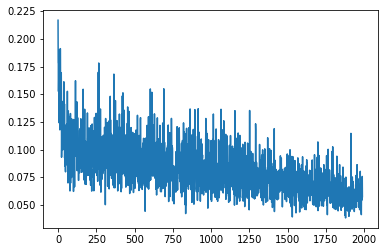

In [42]:
loss = torch.Tensor(loss).flatten()

plt.plot(loss)
